# Chapter 3. 평가
## 3.1 정확도(Accuracy)

In [1]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit()메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros( (X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i]=0
            else:
                pred[i]=1
        return pred

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

#Null 처리 함수
def fillna(df):
    df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_feature(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_feature(df)
    df = format_features(df)
    return df


#원본 데이터를 재로딩, 데이터 가공 학습/테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [5]:
# 위에서 생성한 Dummy Classifier를 활용해서 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도: {0: .4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도:  0.7877


위와 같은 단순한 알고리즘으로 예측을 하더라도 데이터 구성에 따라 정확도는 78.77%로 매우 높은 수치로 나올 수 있기 때문에 정확도를 평가지표로 사용할 때는 매우 신중해야 함.

특히, 불균형한 레이블 값 분포에서 모델 성능을 판단할 경우에는 적합한 평가 지표가 아님

예를 들어, 100개의 데이터 중 90개의 레이블이 0, 10개의 레이블이 1인 경우에 무조건 0을 반환하는 모델을 만들면 정확도가 90%가 됨

- MNIST 데이터 세트를 변환하여 불균형한 데이터 세트를 만든 뒤 정확도 지표 적용시 어떤 문제가 발생할 수 있는지 살펴보기

MNIST 데이터세트: 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit을 예측하는데 사용

0부터 9까지의 멀티레이블이지만 True, 나머지는 False인 불균형한 데이터 세트로 변환

이후에 모든 데이터를 False(0)으로 예측하는 분류기를 만들어 정확도를 측정

결과적으로 아무것도 하지 않고, 특정 결과로만 결과를 반환해도 정확도가 높게 측정되어 모델 성능이 높게 나타나는 현상이 발생

In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
        
# 사이킷런의 내장 데이터 셋인 load_digits()를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 이를 astype(int)로 1로 변환, 7이 아니면 False이고 0으로 변환
y=(digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [7]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 데이터 크기: ', y_test.shape)
print('테스트 데이터 세트 레이블 0과 1의 분포도: ')
print(pd.Series(y_test).value_counts())

# FakeClassifier를 통해 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fake_prediction = fakeclf.predict(X_test)
print('모든 예측을 0으로 했을 때의 정확도: ', accuracy_score(y_test, fake_prediction))

레이블 테스트 데이터 크기:  (450,)
테스트 데이터 세트 레이블 0과 1의 분포도: 
0    405
1     45
dtype: int64
모든 예측을 0으로 했을 때의 정확도:  0.9


위와 같이 단순히 한 가지 값만으로 결과를 반환해도 정확도의 90%를 나타냄

이처럼 정확도 평가지표는 불균형한 레이블 데이터 셋에서는 성능지표로 사용되서는 안됨

#### → 이를 극복하기 위해 정확도는 여러 지표와 함께 적용되어야 함

## 3.2 오차 행렬
- 오차행렬(confusion matrix): 학습된 분류 모델이 예측을 수행하면서 얼마나 confused 하는지 보여주는 지표

- TN(TrueNegative): 예측값 Negative(0), 실제값도 Negative(0)
- FP(FalsePositive): 예측값 Positive(1), but 실제값은 Negative(0)
- FN(FalseNegative): 예측값 Negative(0), but 실제값은 Positive(1)
- TP(TruePositive): 예측값 Positive(1), 실제값도 Positive(1)

In [8]:
# MyFakeClassifier의 예측 결과인 fakepred와 실제결과인 y_test를 confusion_matrix의 인자로 입력해서 출력
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fake_prediction)

array([[405,   0],
       [ 45,   0]], dtype=int64)

- TN(TrueNegative): array[0,0] 405
- FP(FalsePositive): array[0,1] 45
- FN(FalseNegative): array[1,0] 0
- TP(TruePositive): array[1,1] 0

### 정확도 = 예측결과와 실제값이 동일한 건수 / 전체 데이터 수 = (TN+TP)/(TN+FP+FN+TP)

## 3.3 정밀도와 재현율

In [9]:
# 사이킷런의 정확도, 정밀도, 재현율, 오차행렬을 계산하는 API 호출
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 호출한 지표들을 한꺼번에 계산하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))

In [10]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측 후 평가 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869


C:\Users\minjipark\anaconda3\envs\ESAA\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도/재현율 트레이드오프

In [11]:
# 타이타닉  생존자 데이터에서 predict() 결과 값과 predict_proba() 결과 값을 비교
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba의 shape: {0}'.format(pred_proba.shape))
print('pred_proba의 array에서 앞 3개만 샘플로 추출 :\n', pred_proba[:3])

#예측확률 array와 예측 결과값 array를 병합하여 예측확률과 결괏값을 한 번에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba의 shape: (179, 2)
pred_proba의 array에서 앞 3개만 샘플로 추출 :
 [[0.46161968 0.53838032]
 [0.87858765 0.12141235]
 [0.87723954 0.12276046]]
두 개의 class 중 더 큰 확률을 클래스 값으로 예측
 [[0.46161968 0.53838032 1.        ]
 [0.87858765 0.12141235 0.        ]
 [0.87723954 0.12276046 0.        ]]


In [12]:
from sklearn.preprocessing import Binarizer

# 예시
X = [[-1, -1, 2],
        [2, 0, 0], 
        [0, 1.1, 1.2]]

# X의 개별원소들이 threshold보다 크면 1, 작거나 같으면 0을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


- 앞선 Logistic Regression 객체의 predict_proba()의 결과 값에 Binarizer클래스를 적용하여 최종 예측 값을 구하고, 최종 예측 값에 대해 평가해보기

In [13]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 값을 0.5로 설정
custom_threshold = 0.5

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869


In [14]:
# Binarizer의 threshold 값을 0.4로 설정
custom_threshold = 0.4

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[99 19]
 [10 51]]
정확도 : 0.8380
정밀도 : 0.7286
재현율 : 0.8361


- threshold를 낮추니 정밀도 down, 재현율 up
##### 임곗값을 0.4부터 0.6까지 0.05씩 증가시킨 평가지표

In [15]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

# 평가지표를 조사하기 위한 새로운 함수 생성
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차행렬
[[99 19]
 [10 51]]
정확도 : 0.8380
정밀도 : 0.7286
재현율 : 0.8361

임계값:  0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492
정밀도 : 0.7656
재현율 : 0.8033

임계값:  0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869

임계값:  0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659
정밀도 : 0.8364
재현율 : 0.7541

임계값:  0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771
정밀도 : 0.8824
재현율 : 0.7377


##### precision_recall_curve(실제 클래스 값, 예측 확률 값) : 임계값 변화에 따른 평가 지표 값을 반환하는 API

- 반환 값 : 정밀도 - 임계값별 정밀도 값을 배열으로 반환, 재현율 - 임계값별 재현율 값을 배열으로 반환

In [16]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 떄의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[ : , 1]

# 실제값 데이터 세트와 레이블 값이 1일 때 예측확률을 precision_recall_curve의 인자로 반환
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape: ', thresholds.shape)

# 반환된 임계값 배열 로우가 147건 이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율 : ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 shape:  (143,)
샘플 추출을 위한 임계값 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도 :  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


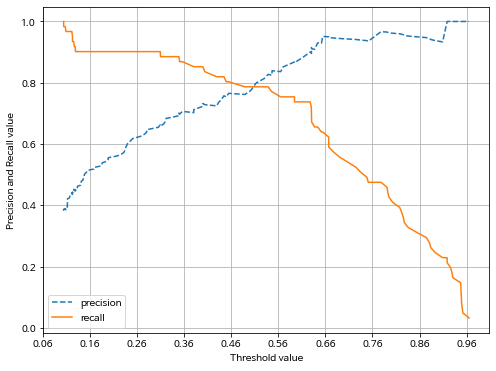

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold 값, y축을 정밀도, 재현율로 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## 3.4 F1 스코어
: 정밀도와 재현율을 결합한 지표로, 정밀도나 재현율이 어느 한 쪽으로 치우지지 않을 때 상대적으로 높은 값을 가짐

In [23]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {:.4f}'.format(f1))

F1 스코어 : 0.7805


타이타닉 생존자 예측에서 임계값을 변화시키며 F1 스코어, 정밀도, 재현율 구하기

In [24]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # F1 score print 추가
    print('\n정확도: {:.4f}\n정밀도: {:.4f}\n재현율: {:.4f}\nF1: {:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)


임계값:  0.4
오차행렬
[[99 19]
 [10 51]]

정확도: 0.8380
정밀도: 0.7286
재현율: 0.8361
F1: 0.7786

임계값:  0.45
오차행렬
[[103  15]
 [ 12  49]]

정확도: 0.8492
정밀도: 0.7656
재현율: 0.8033
F1: 0.7840

임계값:  0.5
오차행렬
[[104  14]
 [ 13  48]]

정확도: 0.8492
정밀도: 0.7742
재현율: 0.7869
F1: 0.7805

임계값:  0.55
오차행렬
[[109   9]
 [ 15  46]]

정확도: 0.8659
정밀도: 0.8364
재현율: 0.7541
F1: 0.7931

임계값:  0.6
오차행렬
[[112   6]
 [ 16  45]]

정확도: 0.8771
정밀도: 0.8824
재현율: 0.7377
F1: 0.8036


## 2.5 ROC 곡선과 AUC
- 재현율/민감도(TPR) = TP / (FN+TP)
- 특이성(TNR) = TN / (TN+FP)
- FPR = 1 - TNR

곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것, 멀어질수록 성능이 뛰어난 것

In [25]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되 임계값을 5step으로 추출
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index], 2))

# 5 step으로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index 10개:  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값:  [0.97 0.65 0.63 0.56 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임계값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임계값별 TPR:  [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


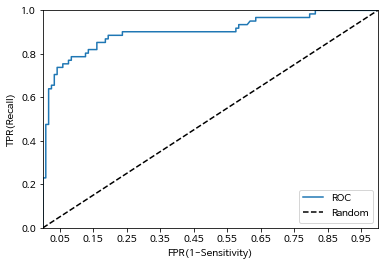

In [26]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을반환 받음
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    # ROC곡선을 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

- AUC(Area Under Curve): 곡선 밑의 면적 값. 1에 가까울수록 좋은 수치, ROC 곡선이 대각선 직선일 때에는 0.5

In [27]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

ROC AUC 값 : 0.8341
